In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import numpy as np
import glob

In [62]:
(train_image,train_label),(_,_)=tf.keras.datasets.mnist.load_data()

In [63]:
train_image.shape

(60000, 28, 28)

In [64]:
train_image=train_image.reshape(train_image.shape[0],28,28,1).astype('float32') ##擴充到3D,

In [65]:
train_image.shape

(60000, 28, 28, 1)

In [66]:
train_image=(train_image-127.5)/127.5   ###數值歸一,映射到-1~1

In [67]:
dataset=tf.data.Dataset.from_tensor_slices(train_image)

In [68]:
dataset

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>

In [69]:
BATCH_SIZE=256

In [70]:
dataset = dataset.shuffle(60000).batch(BATCH_SIZE)  ###亂數,batch

In [71]:
dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [72]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256,input_shape=(100,),use_bias=False))  ####100為輸入亂數大小,use_bias為偏置向量
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(512,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(28*28*1,use_bias=False,activation='tanh'))  ##取值為-1~1 使用 tanh
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((28,28,1)))
    
    return model
    
    

In [73]:
def discriminator_model():
    model = keras.Sequential()
    
    model.add(layers.Flatten())              
    
    model.add(layers.Dense(512,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(256,use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    
    return model

In [74]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) ## from_logits=True最後一層未使用激活

GAN優化目標函數

In [75]:
def discriminator_loss(real_image,fake_out):
    read_loss =cross_entropy(tf.ones_like(real_image),real_image)    ##希望real 判別為1
    fake_loss =cross_entropy(tf.zeros_like(fake_out),fake_out)       ##希望fake 判別為0
    return read_loss+fake_loss

In [76]:
def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out),fake_out)           ##希忘fake 判別為1

In [77]:
generator_opt = tf.keras.optimizers.Adam(1e-4)
discriminator_opt = tf.keras.optimizers.Adam(1e-4)

In [78]:
EPOCHS=30
noise_dim=100

num_exp_to_generate =16

seed=tf.random.normal([num_exp_to_generate,noise_dim])  #######驗證測試

In [79]:
discriminator=discriminator_model()

In [80]:
generator=generator_model()

In [81]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])   #
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   ##追蹤gen,disc
        ###目標函數式子
        real_out = discriminator(images,training=True)   
        
        gen_image =generator(noise,training=True)
        fake_out = discriminator(gen_image,training=True)
        ###
        gen_loss=generator_loss(fake_out)
        disc_loss=discriminator_loss(real_out,fake_out)
    ##計算gradient
    gradient_gen = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    ##優化
    generator_opt.apply_gradients(zip(gradient_gen,generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradient_disc,discriminator.trainable_variables))

In [85]:
def genrate_plot_image(gen_model,test_noise):    ####可視化
    pre_images = gen_model(test_noise,training=False)  
    fig = plt.figure(figsize=(4,4))
    for i in range (pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(( pre_images[i,:,:,0]+1)/2 ,cmap='gray')   #### 因tanh取值範圍在-1~1 將值取回0~1
        plt.axis('off')
    plt.show()

In [86]:
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
            print('',end='')
        genrate_plot_image(generator,seed)

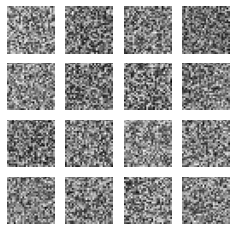

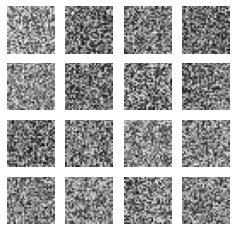

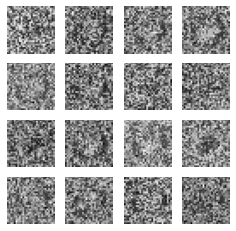

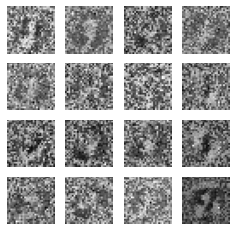

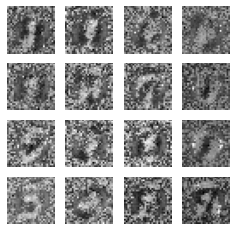

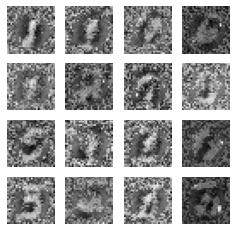

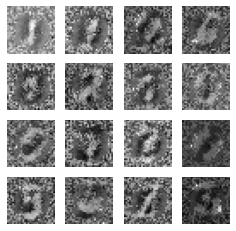

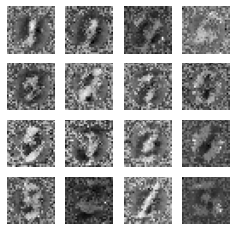

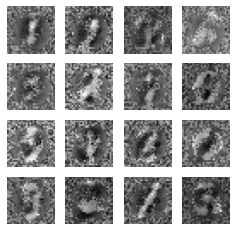

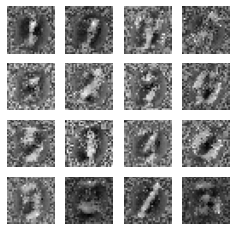

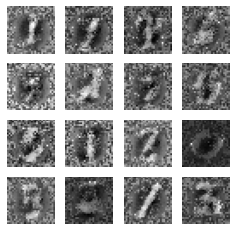

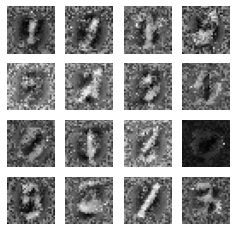

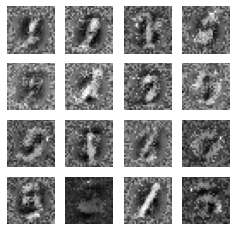

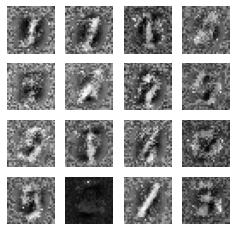

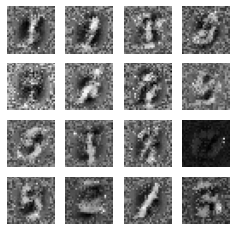

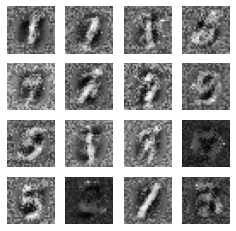

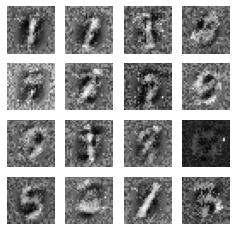

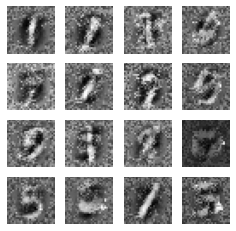

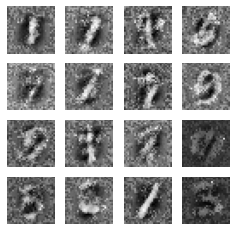

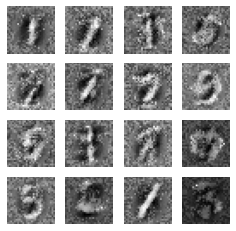

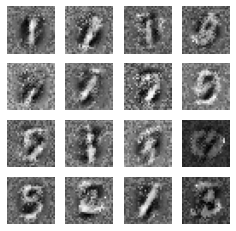

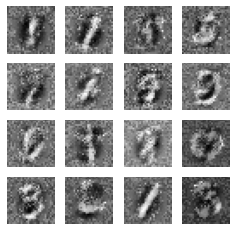

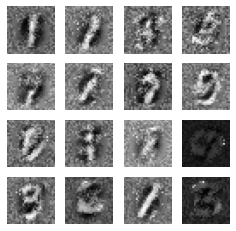

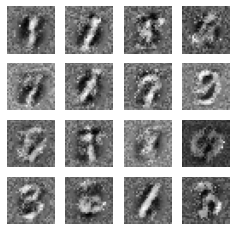

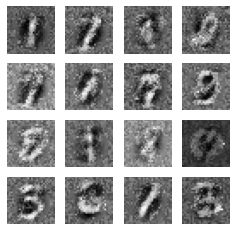

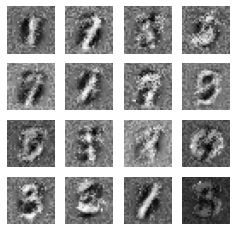

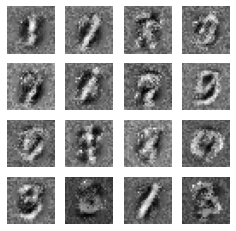

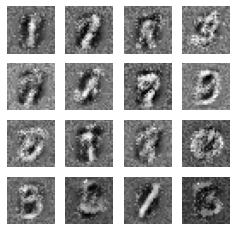

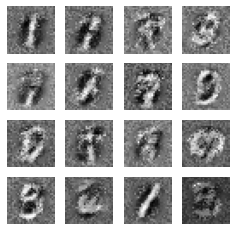

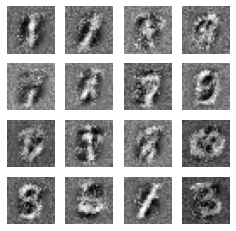

In [87]:
train(dataset,EPOCHS)